# Кинетика социального неравенства

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from collections import OrderedDict
from collections import Counter

Реализация класса "City", озволящего проводить моделирование по задаваемым параметрам. Можно задавать число людей, среднее количество денег, а также параметры эксперимента. Используется нормированный MSE лосс. Позволяет наблюдать за изменением распределения в реальном времени.

In [168]:
class City():
 
    def __init__(self, s_ = 100, N = 10000):
        """Constructor"""
        self.s_ = s_
        self.N = N
        self.people = OrderedDict({})
        self.s_max = self.s_*self.N
        self.total_iters = 0
        self._make_people()
        
        self.theoretical_distribution = np.array(np.exp((-1 * np.arange(0,self.s_max))/self.s_) * 1/self.s_ , dtype = float)
        self.quant_th_distr = self.quantize_vector(self.theoretical_distribution, self.N)
        
        self.loss_hist = []
        self.last_mean = None
        self.previous_last_mean = None
    
    def _make_people(self):
        
        for i in range(self.N):
            self.people[i] = self.s_
            
    def quantize_vector(self, theory, N):
        step = 1 / N
        quantized = np.zeros(len(theory))
        for money in range(len(theory)):
            quantized[money] = theory[money] // step * step
            if theory[money] % step > step/2:
                quantized[money]+=step
        return quantized
    
    def _calculate_loss(self):

        uniq = Counter(list(self.people.values()))
        money = list(uniq)
        money.sort()
        sorted_dist = []
        for m in money:
            sorted_dist.append(uniq[m])
        sorted_dist = np.array(sorted_dist) / self.N
        loss = 0
        gts = []
        for i,m in enumerate(money):
            gt = self.quant_th_distr[m]
            gts.append(gt**2)
            exp = sorted_dist[i]
            loss += (gt-exp)**2
            
        loss_final = np.sqrt(loss/np.sum(gts)/(len(sorted_dist)))

        return loss_final, money, sorted_dist
    
    def start_life(self, epochs = 10000, bet = 1, loss_every = 100, display_epochs =1000, pations = 1000):
        
        for epoch in range(epochs):
            first_peoples = np.random.choice(list(self.people), int(self.N/2), replace = False)
            second_peoples = [x for x in list(self.people) if x not in first_peoples]
            np.random.shuffle(second_peoples)
            temp_money = None
            temp_sorted_dist = None
            for it, (f_p, s_p) in enumerate(zip(first_peoples, second_peoples)):
                stavka = 0
                if self.people[f_p] != 0:
                    stavka+=bet
                    self.people[f_p]-=bet
                if self.people[s_p] != 0:
                    stavka+=bet
                    self.people[s_p]-=bet  
                if np.random.random()>0.5:
                    self.people[f_p]+=stavka
                else:
                    self.people[s_p]+=stavka
                    
                if self.total_iters % loss_every == 0:
                    loss, temp_money, temp_sorted_dist = self._calculate_loss()
                    self.loss_hist.append(loss)
                self.total_iters+=1
                    
            if epoch%display_epochs == 0:
                clear_output(True)
                print('Epoch:', epoch)
                print('Loss:', loss)
                print('Num points:', len(temp_money))
                print('last_mean:', self.last_mean)
                print('previous_last_mean:', self.previous_last_mean)
                plt.figure(figsize = (15,10))
                plt.plot(self.quant_th_distr, c = 'b')
                plt.scatter(temp_money, np.array(temp_sorted_dist), c = 'red')
                plt.xlim([0, max(temp_money)+50])
                plt.grid()
                plt.show()
                
            if pations is not None and len(self.loss_hist)>2*pations:
                self.last_mean = np.mean(self.loss_hist[-pations:])
                self.previous_last_mean = np.mean(self.loss_hist[-2*pations:-pations])
                if self.last_mean >= self.previous_last_mean:
                    print("Loss has stabilized. End of training.")
                    break
                
        return self.people, self.loss_hist, self.total_iters
                    

Создадим класс города и построим ожидаемое теоретическое распределение богатств, которое зависит только от среднего числа монет у людей.

Text(0, 0.5, 'Fraction')

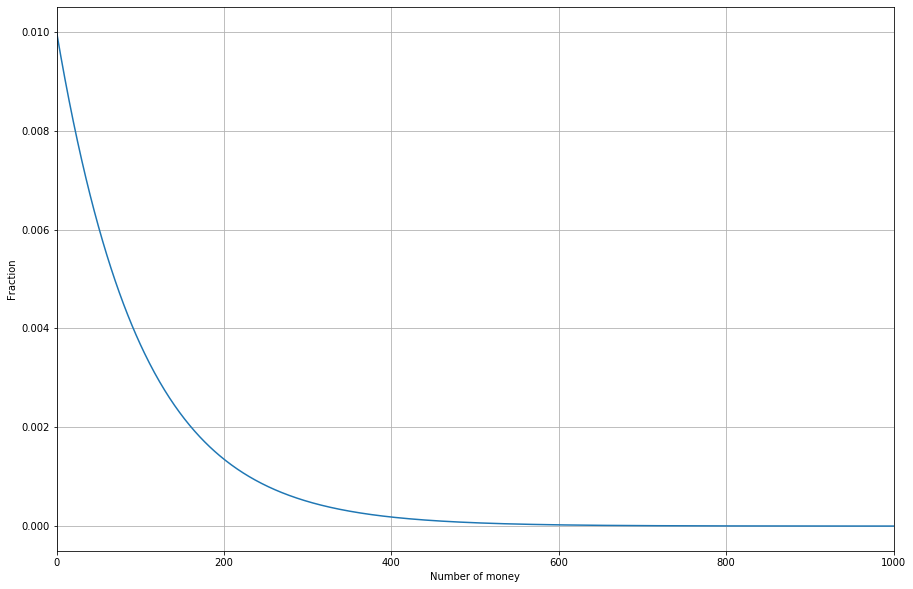

In [243]:
plt.figure(figsize = (15,10))
city_1000 = City(s_ = 100, N = 1000)
plt.plot(city_1000.theoretical_distribution, label = 'Theoretical')
plt.xlim([0, 1000])
plt.grid()
plt.xlabel('Number of money')
plt.ylabel('Fraction')

Это непрерывное распределение по оси Fraction. Однако в наших экспериментах участвует ограниченное дискретное число людей, поэтому результатом такого моделирования не может быть непрерывное распределение. Оно будет дискретно по оси Fraction и чем меньше будет участвовать людей в эксперименте, тем более "крупными" будут занимаемые уровни. Шаг между уровнями при этом равняется 1/N, где N - общее число людей. Пример для N = 1000 - на рисунке ниже. Сравнение сходимости дискретного распределения с непрерывным теоретическим имеет в нашей ситуации 2 проблемы:

    1) Наличие постоянного "фиктивного лосса", возникающего из-за дискретности эксперимента.

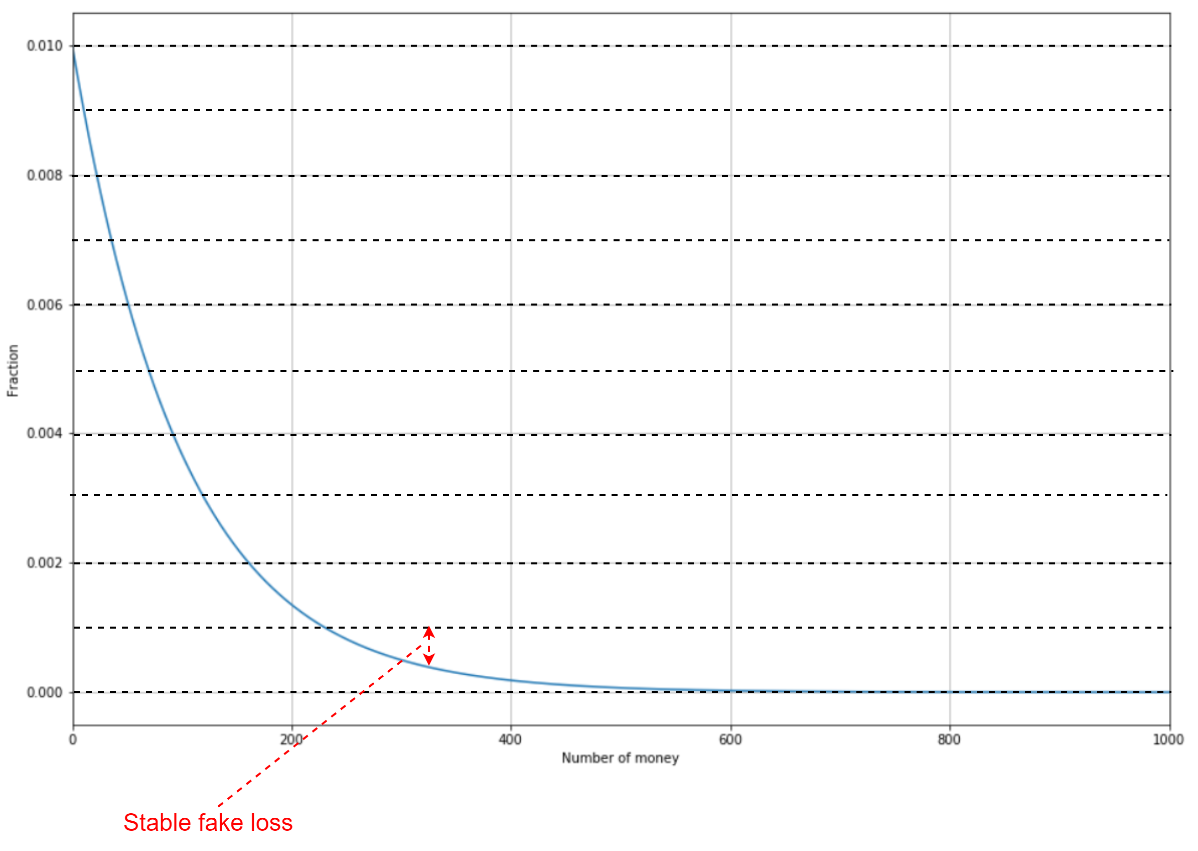

    Для уменьшения влияния первой проблемы было решено квантовать теоретическое распределение и считать лосс относительно      квантованного распределения. (Примеры квантованных  распределений показаны ниже.)
    
    2) Проблема разного масштаба реальных лоссов для разных N. Ошибка точки в уровне в эксперименте с малым числом N вносит значительно больший вклад в лосс, чем ошибка в эксперименте с большим N. Поэтому нельзя сравнивать лоссы между экспериментами с разным N и нельзя выбрать универсальное значение лосса для всех экспериментов, по которому мы будем оценивать сходимость эксперимента.

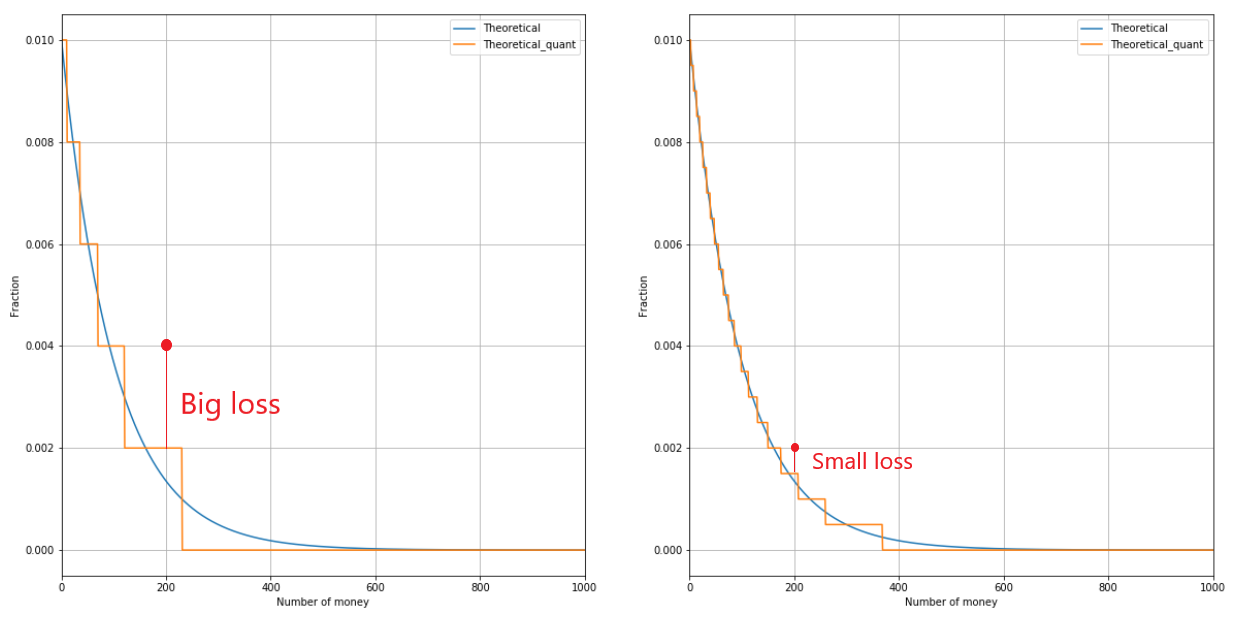

Таким образом имеется проблема оценки сходимости эксперимента. Я пытался решить эту проблему по разному - нормирование лосса, сохранение числа уровней между экспериментами и тд. Однако наиболее эффективным решением оказалось заимствование из практики обучения нейронных сетей подхода с pations и его модификация для нашего случае. Стандартный подход - прерывание обучения алгоритма после определенного числа эпох, если лосс не уменьшался в течение этих эпох. В нашем случае имеют место случайные процессы, которые могут вызывать значительные осцилляции лосса даже тогда, когда алгоритм уже сошелся, поэтому в этом виде алгоритм работает не очень хорошо. Поэтому я модифицировал этот подход и считаю pations усредняя лоссы в скользящих окнах фиксированного размера. То есть эксперимент будет считаться сошедшимся, если средний лосс за последние 1000 (например) эпох больше либо равен среднему лоссу за предпоследние 1000 эпох. Данный подход позволил достаточно надежно определять сходимость эксперимента.

(0, 1000)

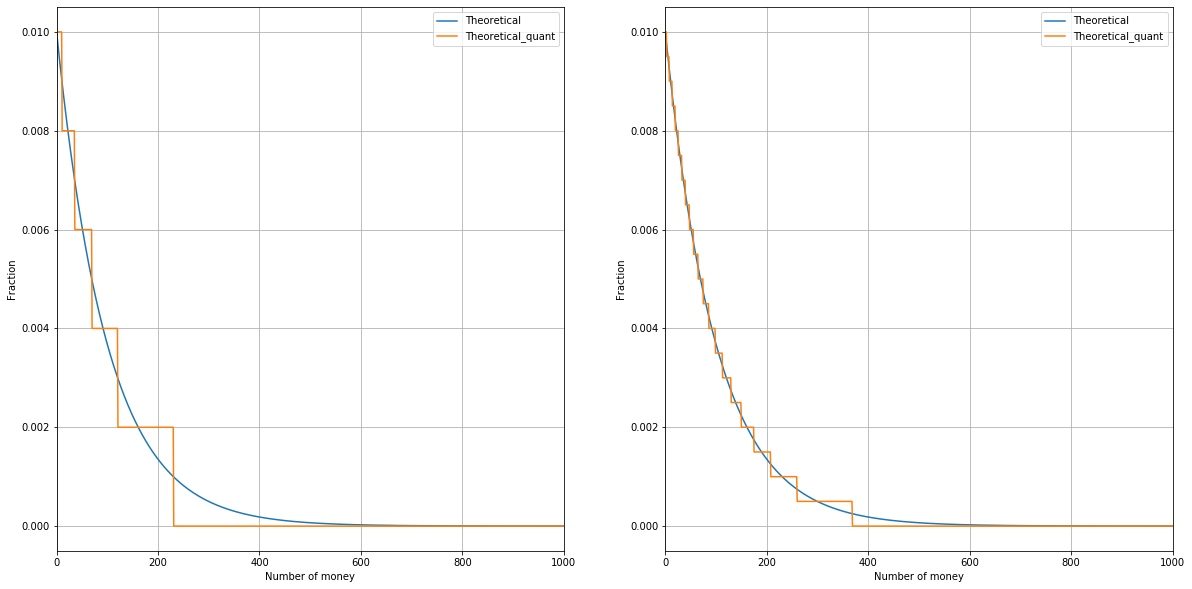

In [248]:
#здесь можно поиграться с целевыми распределениями
plt.figure(figsize = (20,10))

city_500 = City(s_ = 100, N = 500)
city_2000 = City(s_ = 100, N = 2000)
plt.subplot(1,2,1)
plt.plot(city_500.theoretical_distribution, label = 'Theoretical')
plt.plot(city_500.quant_th_distr, label = 'Theoretical_quant')
plt.legend()
plt.grid()
plt.xlabel('Number of money')
plt.ylabel('Fraction')
plt.xlim([0, 1000])

plt.subplot(1,2,2)
plt.plot(city_2000.theoretical_distribution, label = 'Theoretical')
plt.plot(city_2000.quant_th_distr, label = 'Theoretical_quant')
plt.legend()
plt.grid()
plt.xlabel('Number of money')
plt.ylabel('Fraction')
plt.xlim([0, 1000])

In [ ]:
city_test = City(s_ = 100, N = 5000)
people_test, loss_hist_test, total_iters_test = city_test.start_life(epochs = 60000, bet = 1, loss_every = 2500, display_epochs =100, pations = 1000)

Далее проводится ряд экспериментов для разных N при фиксированном начальном распределении. Каждый эксперимент проводится 3 раза, чтобы потом усреднить его результаты (хотя и этого по итогу оказалось мало). Используется следующая модель:

   На момент старта все люди имеют одинаковое количество монет. Каждый "день" (эпоху) все люди разбиваются на пары случайным образом, разбитие происходит без повторений (то есть один и тот же человек играет только один раз в день). В каждой паре люди делают ставку (в дальнейших экспериментах - 1) и подбрасывают монетку, определяя кто заберет банк. Если у человека нет денег, то он не вносит свою ставку.

# N = 1000

Epoch: 14900
Loss: 0.02683261881392067
Num points: 277
last_mean: 0.02744808035213673
previous_last_mean: 0.02758409177431029


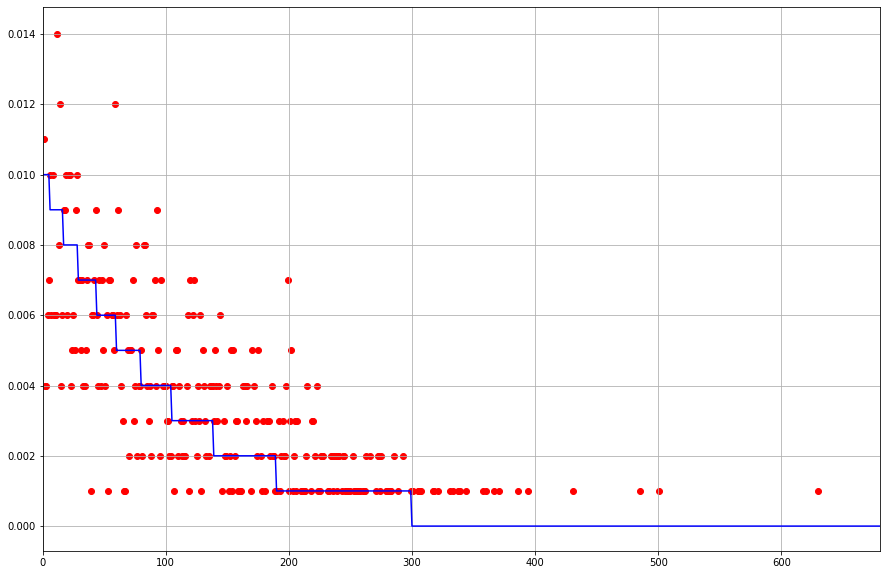

Loss has stabilized. End of training.


In [181]:
people_1000_3 = []
loss_hist_1000_3 = []
total_iters_1000_3 = []

for _ in range(3):
    city_1000 = City(s_ = 100, N = 1000)
    people_1000, loss_hist_1000, total_iters_1000 = city_1000.start_life(epochs = 60000, bet = 1, loss_every = 500, display_epochs =100, pations = 1000)
    people_1000_3.append(people_1000)
    loss_hist_1000_3.append(loss_hist_1000)
    total_iters_1000_3.append(total_iters_1000)

In [182]:
total_iters_1000_3

[5314000, 6520500, 7482500]

# N = 2000

Epoch: 15700
Loss: 0.017801340364737565
Num points: 334
last_mean: 0.01892230791857326
previous_last_mean: 0.01894185381413362


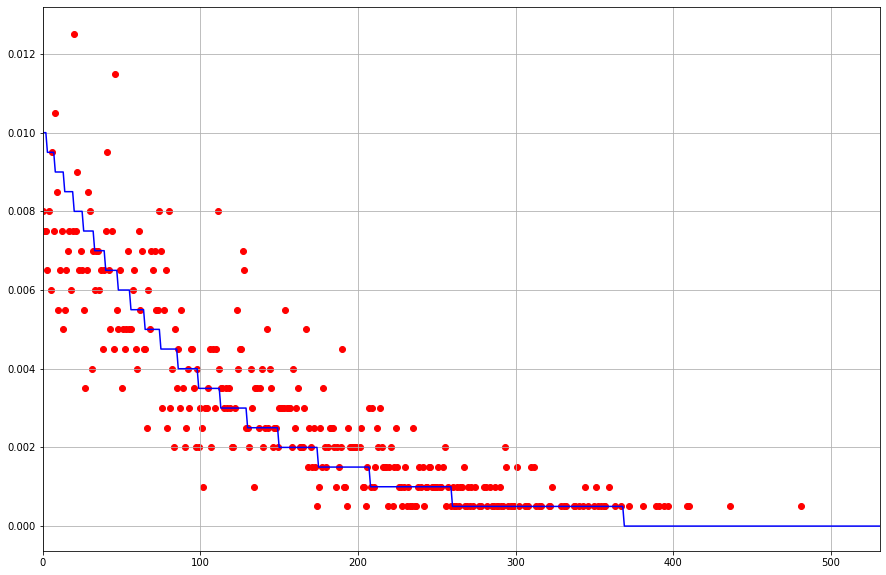

Loss has stabilized. End of training.


In [183]:
people_2000_3 = []
loss_hist_2000_3 = []
total_iters_2000_3 = []

for _ in range(3):
    city_2000 = City(s_ = 100, N = 2000)
    people_2000, loss_hist_2000, total_iters_2000 = city_2000.start_life(epochs = 60000, bet = 1, loss_every = 1000, display_epochs =100, pations = 1000)
    people_2000_3.append(people_2000)
    loss_hist_2000_3.append(loss_hist_2000)
    total_iters_2000_3.append(total_iters_2000)

In [184]:
total_iters_2000_3

[19601000, 18103000, 15711000]

# N = 3000

Epoch: 22700
Loss: 0.015398117234414688
Num points: 369
last_mean: 0.014314478818876932
previous_last_mean: 0.014364486562500826


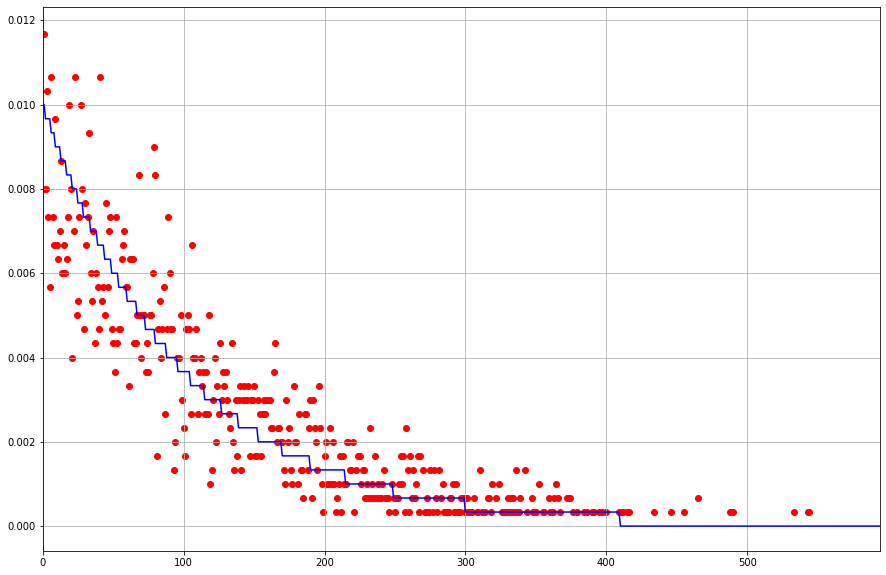

Loss has stabilized. End of training.


In [185]:
people_3000_3 = []
loss_hist_3000_3 = []
total_iters_3000_3 = []

for _ in range(3):
    city_3000 = City(s_ = 100, N = 3000)
    people_3000, loss_hist_3000, total_iters_3000 = city_3000.start_life(epochs = 60000, bet = 1, loss_every = 1500, display_epochs =100, pations = 1000)
    people_3000_3.append(people_3000)
    loss_hist_3000_3.append(loss_hist_3000)
    total_iters_3000_3.append(total_iters_3000)

In [188]:
total_iters_3000_3

[31215000, 26479500, 34197000]

# N = 4000

Epoch: 22300
Loss: 0.01223649049496506
Num points: 379
last_mean: 0.012017197645519551
previous_last_mean: 0.01205565333219715


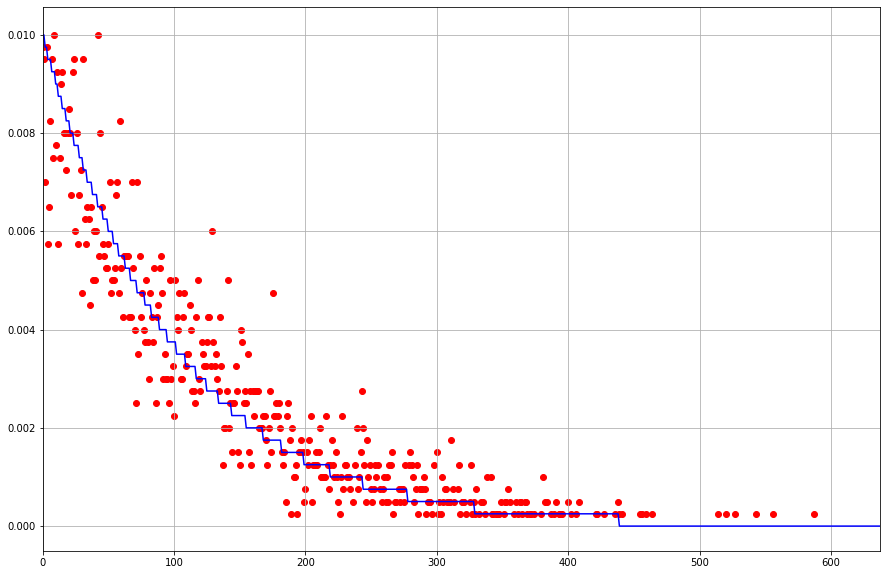

Loss has stabilized. End of training.


In [189]:
people_4000_3 = []
loss_hist_4000_3 = []
total_iters_4000_3 = []

for _ in range(3):
    city_4000 = City(s_ = 100, N = 4000)
    people_4000, loss_hist_4000, total_iters_4000 = city_4000.start_life(epochs = 60000, bet = 1, loss_every = 2000, display_epochs =100, pations = 1000)
    people_4000_3.append(people_4000)
    loss_hist_4000_3.append(loss_hist_4000)
    total_iters_4000_3.append(total_iters_4000)

In [190]:
total_iters_4000_3

[32374000, 41192000, 44668000]

# N = 5000

Epoch: 21100
Loss: 0.012091067894081618
Num points: 392
last_mean: 0.011074682259399286
previous_last_mean: 0.011079461386942508


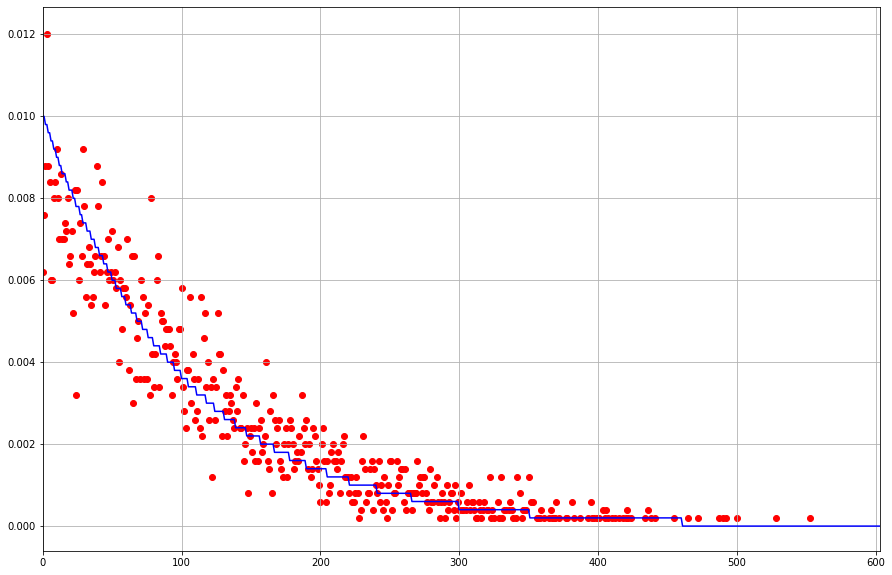

Loss has stabilized. End of training.


In [191]:
people_5000_3 = []
loss_hist_5000_3 = []
total_iters_5000_3 = []

for _ in range(3):
    city_5000 = City(s_ = 100, N = 5000)
    people_5000, loss_hist_5000, total_iters_5000 = city_5000.start_life(epochs = 60000, bet = 1, loss_every = 2500, display_epochs =100, pations = 1000)
    people_5000_3.append(people_5000)
    loss_hist_5000_3.append(loss_hist_5000)
    total_iters_5000_3.append(total_iters_5000)

In [192]:
total_iters_5000_3

[56187500, 62225000, 52795000]

# N = 7000

Epoch: 21400
Loss: 0.00965116172560621
Num points: 413
last_mean: 0.009161758422547727
previous_last_mean: 0.009219394459620655


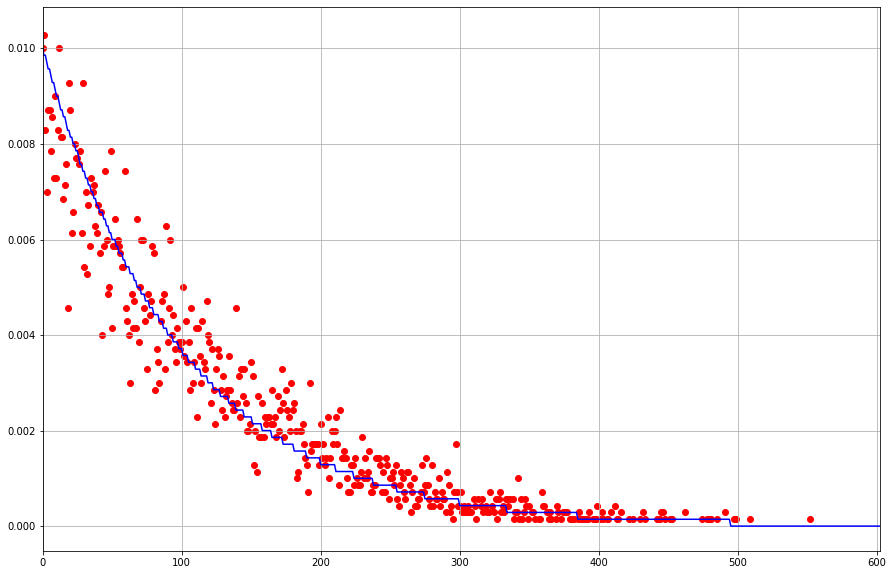

Loss has stabilized. End of training.


In [193]:
people_7000_3 = []
loss_hist_7000_3 = []
total_iters_7000_3 = []

for _ in range(3):
    city_7000 = City(s_ = 100, N = 7000)
    people_7000, loss_hist_7000, total_iters_7000 = city_7000.start_life(epochs = 60000, bet = 1, loss_every = 3500, display_epochs =100, pations = 1000)
    people_7000_3.append(people_7000)
    loss_hist_7000_3.append(loss_hist_7000)
    total_iters_7000_3.append(total_iters_7000)

In [194]:
total_iters_7000_3

[63623000, 90286000, 75197500]

# N = 9000

Epoch: 26200
Loss: 0.007876192654214851
Num points: 447
last_mean: 0.007822197287020384
previous_last_mean: 0.00782374412807039


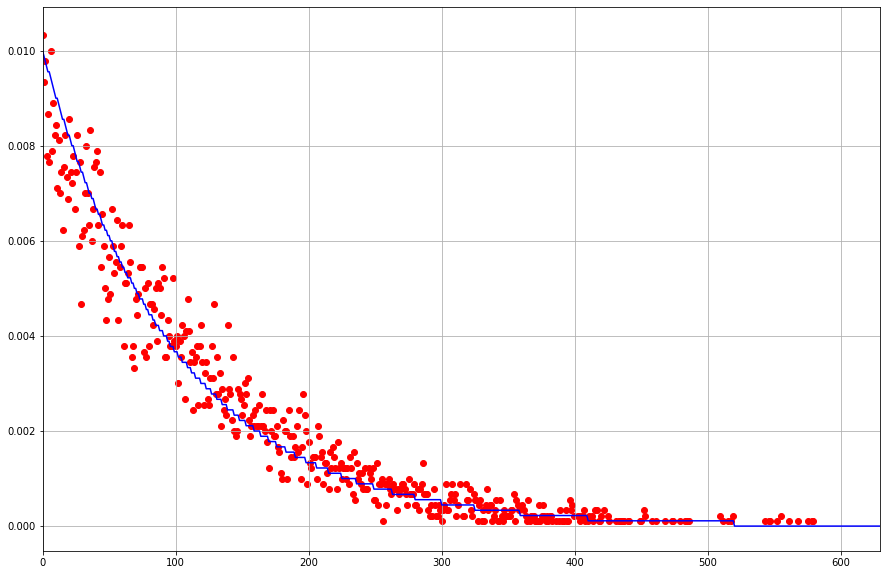

Loss has stabilized. End of training.


In [195]:
people_9000_3 = []
loss_hist_9000_3 = []
total_iters_9000_3 = []

for _ in range(3):
    city_9000 = City(s_ = 100, N = 9000)
    people_9000, loss_hist_9000, total_iters_9000 = city_9000.start_life(epochs = 60000, bet = 1, loss_every = 4500, display_epochs =100, pations = 1000)
    people_9000_3.append(people_9000)
    loss_hist_9000_3.append(loss_hist_9000)
    total_iters_9000_3.append(total_iters_9000)

In [196]:
total_iters_9000_3

[113575500, 106186500, 117909000]

# N = 11000

Epoch: 30200
Loss: 0.006787166724153787
Num points: 461
last_mean: 0.006665585952267678
previous_last_mean: 0.006710026042931226


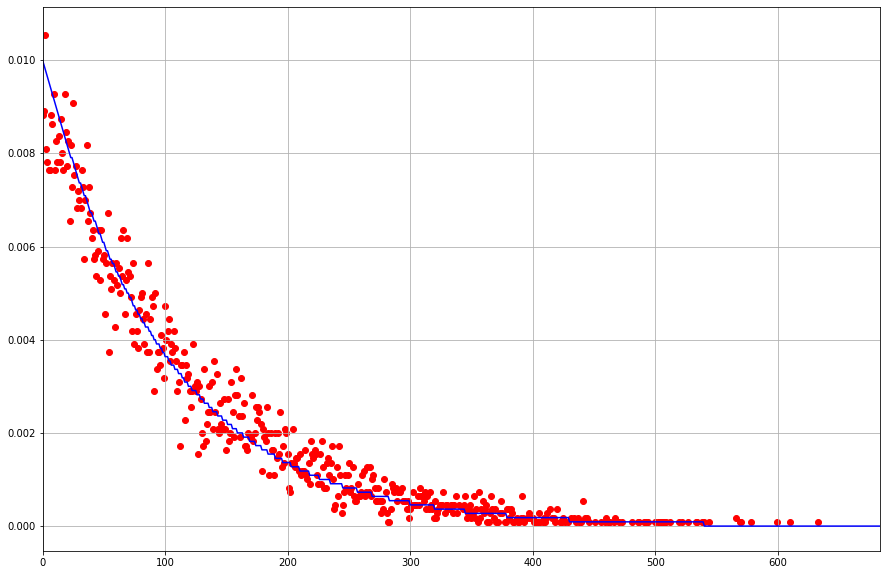

Loss has stabilized. End of training.


In [197]:
people_11000_3 = []
loss_hist_11000_3 = []
total_iters_11000_3 = []

for _ in range(3):
    city_11000 = City(s_ = 100, N = 11000)
    people_11000, loss_hist_11000, total_iters_11000 = city_11000.start_life(epochs = 60000, bet = 1, loss_every = 5500, display_epochs =100, pations = 1000)
    people_11000_3.append(people_11000)
    loss_hist_11000_3.append(loss_hist_11000)
    total_iters_11000_3.append(total_iters_11000)

In [198]:
total_iters_11000_3

[134524500, 141933000, 166628000]

# N = 15000

Epoch: 23100
Loss: 0.006559122052402202
Num points: 455
last_mean: 0.006800184331695889
previous_last_mean: 0.006802092557528564


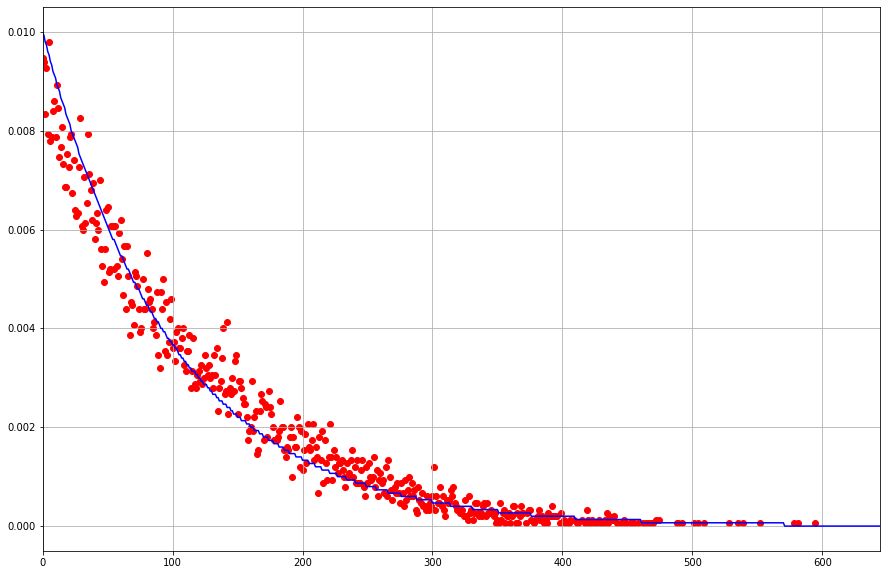

Loss has stabilized. End of training.


In [199]:
people_15000_3 = []
loss_hist_15000_3 = []
total_iters_15000_3 = []

for _ in range(3):
    city_15000 = City(s_ = 100, N = 15000)
    people_15000, loss_hist_15000, total_iters_15000 = city_15000.start_life(epochs = 60000, bet = 1, loss_every = 7500, display_epochs =100, pations = 1000)
    people_15000_3.append(people_15000)
    loss_hist_15000_3.append(loss_hist_15000)
    total_iters_15000_3.append(total_iters_15000)

In [256]:
# некоторые эксперименты считались в другом ноутбуке, здесь их результаты
total_iters_1500_3 = [15134250, 8376000, 13503000]
total_iters_2500_3 = [24907500, 19711250, 22311250]
total_iters_6000_3 = [60942000, 81297000, 71553000]
total_iters_17000_3 = [206363000, 233036000, 216078500]
total_iters_19000_3 = [288496000, 225682000]

# Исследование зависимости

Проверим согласуются ли результаты экспериментов с ожидаемым теоретическим поведением, а именно оценку времени сходимости:
$$t>=aN lnN$$

In [257]:
#строим вектор значений правой части неравенства
Ns = np.array([1000,1500,2000,2500,3000,4000,5000,6000,7000,9000,11000,15000, 17000, 19000])
lnNs = np.log(Ns)
th = Ns*lnNs

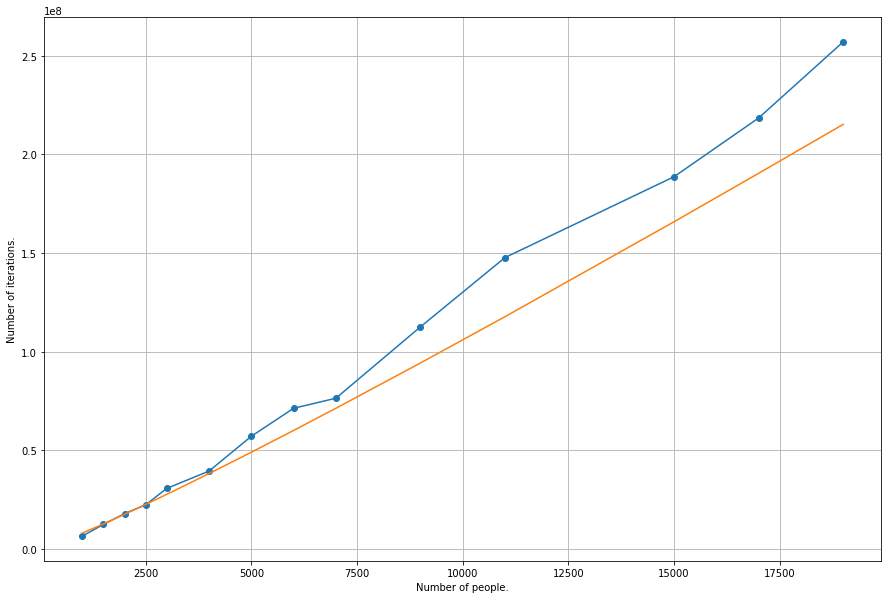

In [258]:
plt.figure(figsize = (15,10))
plt.plot([1000,1500,2000,2500,3000,4000,5000,6000,7000,9000,11000, 15000, 17000, 19000], [np.mean(total_iters_1000_3),
                                                                          np.mean(total_iters_1500_3),
                                                                          np.mean(total_iters_2000_3),
                                                                          np.mean(total_iters_2500_3),
                                                                          np.mean(total_iters_3000_3),
                                                                          np.mean(total_iters_4000_3),
                                                                          np.mean(total_iters_5000_3),
                                                                          np.mean(total_iters_6000_3),
                                                                          np.mean(total_iters_7000_3),
                                                                          np.mean(total_iters_9000_3),
                                                                          np.mean(total_iters_11000_3),
                                                                          np.mean(total_iters_15000_3),
                                                                          np.mean(total_iters_17000_3),
                                                                          np.mean(total_iters_19000_3)
                                                                         ], marker = 'o')
#здесь подбирается коэффициент a, который позволит удовлетворить неравенству и построить графики в равных масштабах
a = 1150
plt.plot([1000,1500,2000,2500,3000,4000,5000,6000,7000,9000,11000,15000, 17000, 19000], th*a)
plt.xlabel('Number of people.')
plt.ylabel('Number of iterations.')
plt.grid()

Таким образом, возможно подобрать такую a, что при обеспечении времени (числа итераций) эксперимента $t>=aN lnN$, обеспечивается сходимость эксперимента. 

Можно сделать следующие выводы:

1. Присутствует явная возрастающая зависимость, однако при данном числе людей тяжело оценить ее вид, поскольку даже теоретическая зависимость на данном промежутке ведет себя почти линейно.
2. Нестабильность экспериментальных точек - вызвана малым числом повторений экспериментов.
3. Формально результаты эксперимента удовлетворяют теоретическому неравенству.
4. Для выявления более определенной формы зависимости необходимо провести эксперименты при значительно большем количестве людей. 